In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [24]:
def get_model_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = [i for i in range(1,len(acc)+1)]
    print(('acc = %0.2f, loss = %0.2f ')%(max(acc),min(loss)))
    print(('val_acc = %0.2f, val_loss = %0.2f ')%(max(val_acc),min(val_loss)))
    
    plt.figure()
    plt.plot(epochs,acc,'bo',label = 'Training acc')
    plt.plot(epochs,val_acc,'b',label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'bo',label = 'Training loss')
    plt.plot(epochs,val_loss,'b',label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Preprocessing the dataset

In [2]:
from thinc.extra.datasets import imdb
imdb_data = imdb()

In [3]:
maxlen = 500 # cutoff text for a max of 100 words
max_words = 10000 # consider only the top 10k words of the database

In [4]:
texts = [d for d in zip(*imdb_data[0])][0]
labels = [d for d in zip(*imdb_data[0])][1]

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray, zeros

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [7]:
## Defininf dictionaries from sequences
word_index = tokenizer.word_index
index_word = { v:k for k,v in word_index.items()} ## just for testing

In [8]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = asarray(labels)

## Preprocessing the Embedded dict

In [9]:
## Reading the Embedded file to create a Dictionary of word:embedded_vector
embeddings_index = {}
f = open('/home/omar/Documents/DataScience/TextML/embeddings/glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = asarray(values[1:], dtype = 'float32')
    except ValueError:
        print(values[1:])
    embeddings_index[word] = coefs
f.close()
print('Found %d word vectors'%len(embeddings_index))

Found 400000 word vectors


In [10]:
## Writing the Emebedded matrix for our 10k specific words
embedding_dim = 100
embedding_matrix = zeros((max_words,embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Traning, validation and test samples

In [11]:
## constants
training_samples = 10000
validation_samples = 1000
test_samples = 1000

x_train =   data[:training_samples]
y_train = labels[:training_samples]

x_val =   data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

x_test =   data[training_samples+validation_samples:training_samples+validation_samples+test_samples]
y_test = labels[training_samples+validation_samples:training_samples+validation_samples+test_samples]

## Defining Model

In [12]:
from keras.models import Model
from keras import Input,layers
from keras.optimizers import RMSprop

In [13]:
print(embedding_matrix.shape)

(10000, 100)


In [22]:
input_text = Input(shape=(maxlen,),dtype='int32',name='seq_text')
embedded_text = layers.Embedding(embedding_matrix.shape[0],
                           embedding_matrix.shape[1],
                           input_length=maxlen,
                           weights = [embedding_matrix],
                           trainable = False)(input_text)
embedded_text = layers.Conv1D(32,7,activation='relu')(embedded_text)
embedded_text = layers.MaxPool1D(5)(embedded_text)
embedded_text = layers.Conv1D(32,7,activation='relu')(embedded_text)
embedded_text = layers.MaxPool1D(5)(embedded_text)
embedded_text = layers.GRU(32,dropout=0.1,recurrent_dropout=0.5)(embedded_text)
embedded_text = layers.Dense(1,activation='sigmoid')(embedded_text)

In [23]:
convnets_gru = Model(input_text,embedded_text)

In [24]:
convneconvnets_gruts_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_text (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
__________

In [25]:
convnets_gru.compile(optimizer=RMSprop(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [26]:
history = convnets_gru.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val,y_val),
                    verbose=False)

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [i for i in range(1,len(acc)+1)]
print(('acc = %0.2f, loss = %0.2f ')%(max(acc),min(loss)))
print(('val_acc = %0.2f, val_loss = %0.2f ')%(max(val_acc),min(val_loss)))

acc = 0.74, loss = 0.53 
val_acc = 0.72, val_loss = 0.55 


<IPython.core.display.Javascript object>


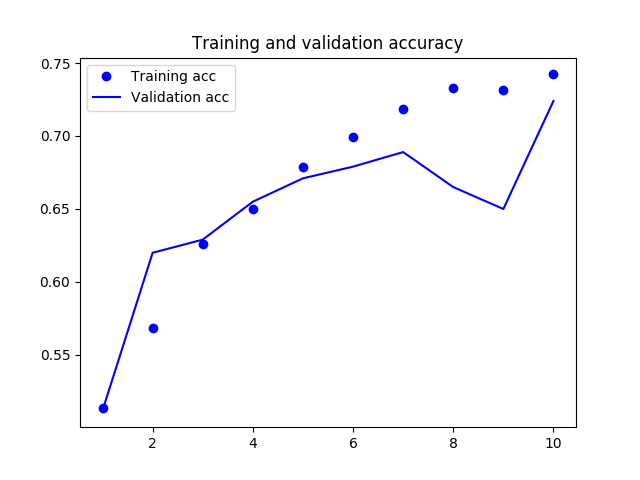

<IPython.core.display.Javascript object>


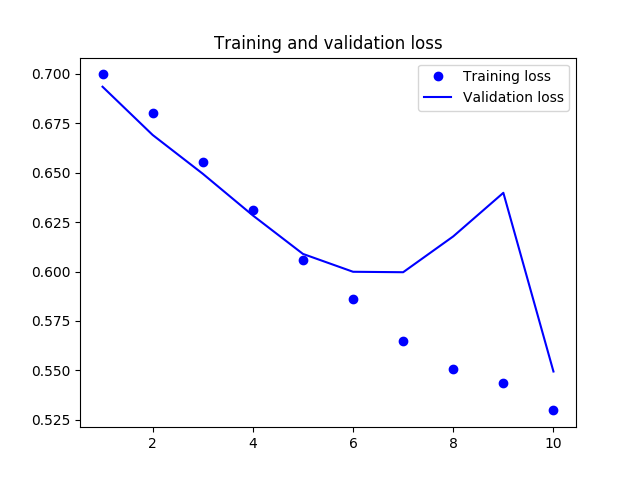

In [29]:
plt.figure()
plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [31]:
convnets_gru.evaluate(x_test,y_test)

1000/1000 [==============================] - 1s 842us/step


[0.5294356274604798, 0.742]

### Contatenating Models

In [55]:
input_text = Input(shape=(maxlen,),dtype='int32',name='seq_text')
embedded_text = layers.Embedding(embedding_matrix.shape[0],
                           embedding_matrix.shape[1],
                           input_length=maxlen,
                           weights = [embedding_matrix],
                           trainable = False)(input_text)

left_branch = layers.Conv1D(32,7,activation='relu')(embedded_text)
left_branch = layers.MaxPool1D(5)(left_branch)
left_branch = layers.Conv1D(32,7,activation='relu')(left_branch)
left_branch = layers.MaxPool1D(5)(left_branch)
left_branch = layers.GRU(32,dropout=0.1,recurrent_dropout=0.5)(left_branch)

#right_branch = layers.Dense(1,activation='softmax',use_bias = False)(embedded_text)
right_branch = layers.Flatten(trainable = False)(embedded_text)
right_branch = layers.Dense(32,activation='softmax')(right_branch)

concatenated_branchs = layers.concatenate([left_branch,right_branch],axis=-1)

output = layers.Dense(1,activation='sigmoid',use_bias = False)(concatenated_branchs)

In [56]:
two_branch_model = Model(input_text,output)

In [57]:
two_branch_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_text (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 500, 100)     1000000     seq_text[0][0]                   
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 494, 32)      22432       embedding_8[0][0]                
__________________________________________________________________________________________________
max_pooling1d_15 (MaxPooling1D) (None, 98, 32)       0           conv1d_15[0][0]                  
__________________________________________________________________________________________________
conv1d_16 

In [58]:
two_branch_model.compile(optimizer=RMSprop(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [59]:
history_tbm = two_branch_model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val,y_val),
                    verbose=False)

<IPython.core.display.Javascript object>


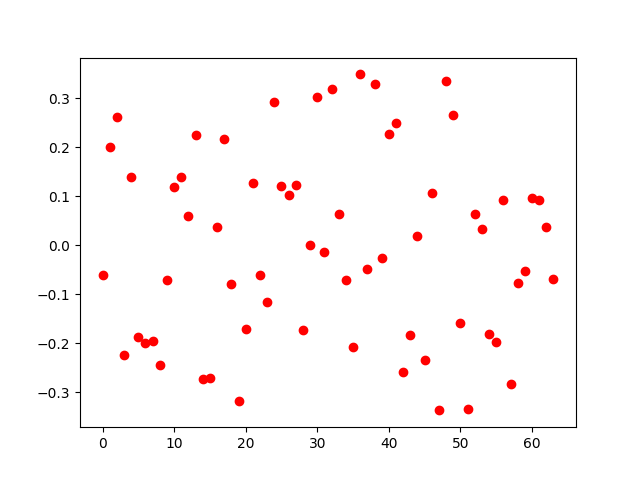

In [60]:
plt.figure()
plt.plot(history_tbm.model.get_weights()[-1],'ro')

acc = 0.80, loss = 0.46 
val_acc = 0.79, val_loss = 0.48 


<IPython.core.display.Javascript object>


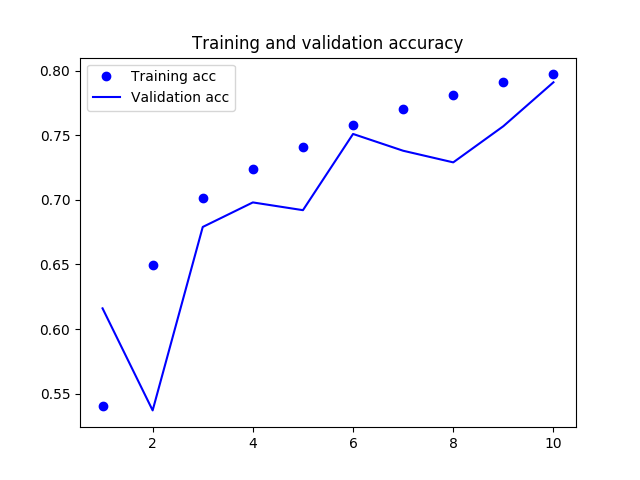

<IPython.core.display.Javascript object>


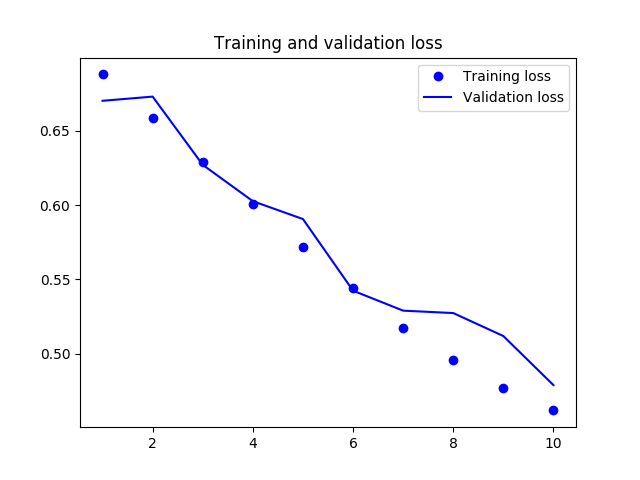

In [61]:
### double Dense Layer with Flaten in the middle
# acc = 0.74, loss = 0.53 
# val_acc = 0.75, val_loss = 0.52 
### double Dense Layer with Flaten in the middle but first Layer with only one hidden unit
#acc = 0.75, loss = 0.52 
#val_acc = 0.75, val_loss = 0.51
### One layer after Flatten
#acc = 0.80, loss = 0.47 
#val_acc = 0.77, val_loss = 0.52
### One layer after Flatten with trainable = False
#acc = 0.80, loss = 0.46 
#val_acc = 0.79, val_loss = 0.48 
get_model_results(history_tbm)